In [35]:
# LIBRARIES USED
# Graphing library of my choice is Plotly
#!pip install plotly
#!pip install pmdarima
#!pip install fitter
import datetime as dt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import n_colors

import pmdarima
import scipy
from fitter import Fitter
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

import backtrader as bt
import matplotlib as mpl
import mplfinance as mpf

# PANDAS OPTIONS
pd.options.plotting.backend = "plotly"
pd.options.display.precision = 2
pd.options.display.float_format = lambda x: f'{x:.2f}'

In [2]:
# Loading data into DataFrame and setting index to DateTimeIndex for easy slicing
df = pd.read_excel('prices_data.xlsx')
df.index = pd.to_datetime(df.loc[:,'Date'], infer_datetime_format=True)
df.drop('Date', axis=1, inplace=True)


# Converting barrels to metric tons
df['Brent'] = df['Brent'] / 0.138
df['Saharan Blend'] = df['Saharan Blend'] / 0.138
df

,Sonatrach Propane,Sonatrach Butane,West Med Propane,West Med Butane,Brent,Saharan Blend
Date,,,,,,
2012-08-31,765,760,973.00,976.50,830.22,820.14
2012-09-30,930,925,986.00,985.00,814.42,804.06
2012-10-31,965,970,1074.50,1080.00,787.68,797.46
2012-11-30,1020,1025,1028.50,981.50,806.01,807.54
2012-12-31,975,980,950.50,880.00,805.14,811.96
...,...,...,...,...,...,...
2022-04-30,870,930,751.60,853.20,792.32,821.45
2022-05-31,730,835,743.60,796.70,890.14,956.38
2022-06-30,730,825,691.40,645.10,831.96,903.55


In [4]:
df.describe()

,Sonatrach Propane,Sonatrach Butane,West Med Propane,West Med Butane,Brent,Saharan Blend
count,121.00,121.00,121.00,121.00,121.00,121.00
mean,517.86,546.35,532.23,549.08,523.84,523.50
std,215.06,215.43,214.68,215.39,183.31,192.34
min,155.00,145.00,189.10,179.00,164.78,114.71
25%,335.00,380.00,350.00,368.44,379.57,370.43
50%,467.00,490.00,500.00,493.20,478.48,480.29
75%,720.00,715.00,710.00,745.00,727.46,725.87
max,1030.00,1120.00,1074.50,1080.00,890.14,956.38


In [137]:
# Spread between propane, butane & Brent
df['C3 / Brent'] = df['Sonatrach Propane'] - df['Brent']
df['C4 / Brent'] = df['Sonatrach Butane'] - df['Brent']
df['C3 / Saharan Blend'] = df['Sonatrach Propane'] - df['Saharan Blend']
df['C4 / Saharan Blend'] = df['Sonatrach Butane'] - df['Saharan Blend']
df

,Sonatrach Propane,Sonatrach Butane,West Med Propane,West Med Butane,Brent,Saharan Blend,C3 / Brent,C4 / Brent,C3 / Saharan Blend,C4 / Saharan Blend
Date,,,,,,,,,,
2012-08-31,765,760,973.00,976.50,830.22,820.14,-65.22,-70.22,-55.14,-60.14
2012-09-30,930,925,986.00,985.00,814.42,804.06,115.58,110.58,125.94,120.94
2012-10-31,965,970,1074.50,1080.00,787.68,797.46,177.32,182.32,167.54,172.54
2012-11-30,1020,1025,1028.50,981.50,806.01,807.54,213.99,218.99,212.46,217.46
2012-12-31,975,980,950.50,880.00,805.14,811.96,169.86,174.86,163.04,168.04
...,...,...,...,...,...,...,...,...,...,...
2022-04-30,870,930,751.60,853.20,792.32,821.45,77.68,137.68,48.55,108.55
2022-05-31,730,835,743.60,796.70,890.14,956.38,-160.14,-55.14,-226.38,-121.38
2022-06-30,730,825,691.40,645.10,831.96,903.55,-101.96,-6.96,-173.55,-78.55


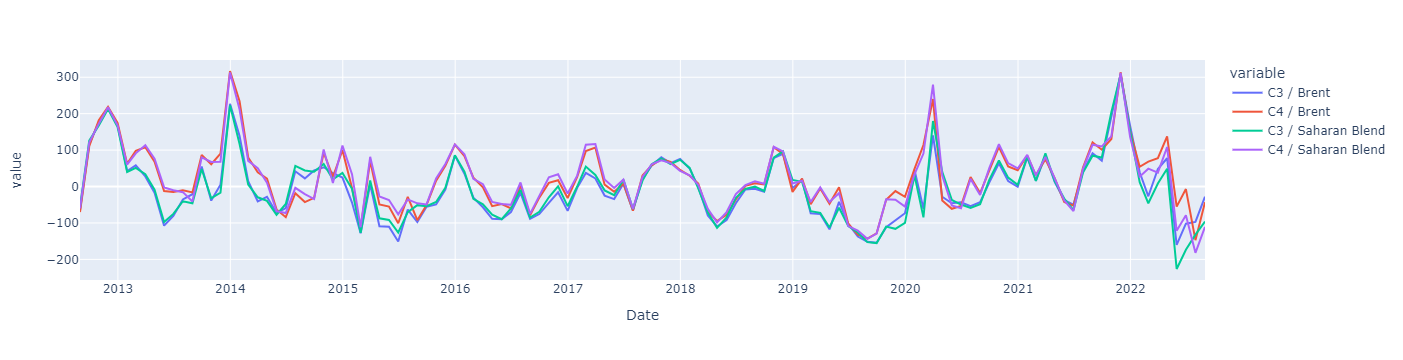

In [139]:
fig_spread = px.line(df.iloc[:,6:])
fig_spread

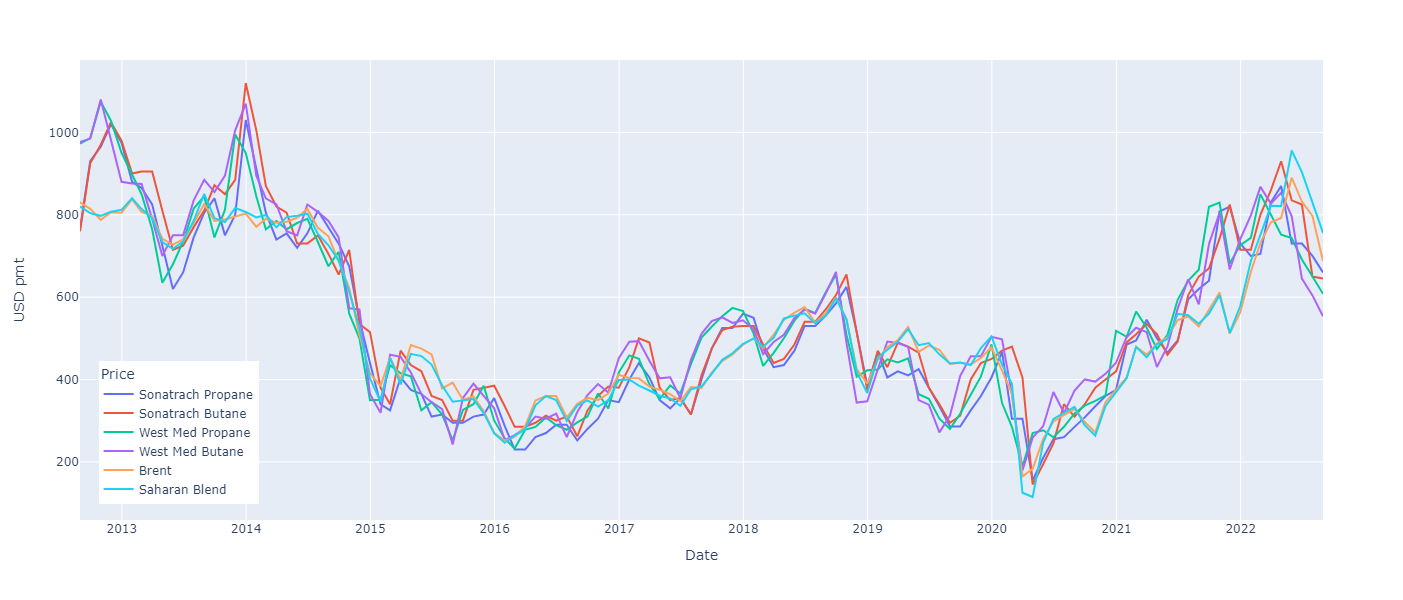

In [154]:
# Plotting prices
fig_prices = px.line(df, labels=dict(value="USD pmt", variable="Price"))

# Figure dimensions
fig_prices.update_layout({"width": 1400,
                          "height": 600})

# Positioning legend
fig_prices.update_layout(legend=dict(
    yanchor="top",
    y=0.345,
    xanchor="left",
    x=0.015
))

fig_prices

In [155]:
# Summary statistics of the dataset
df.describe()

,Sonatrach Propane,Sonatrach Butane,West Med Propane,West Med Butane,Brent,Saharan Blend
count,121.00,121.00,121.00,121.00,121.00,121.00
mean,517.86,546.35,532.23,549.08,523.84,523.50
std,215.06,215.43,214.68,215.39,183.31,192.34
min,155.00,145.00,189.10,179.00,164.78,114.71
25%,335.00,380.00,350.00,368.44,379.57,370.43
50%,467.00,490.00,500.00,493.20,478.48,480.29
75%,720.00,715.00,710.00,745.00,727.46,725.87
max,1030.00,1120.00,1074.50,1080.00,890.14,956.38


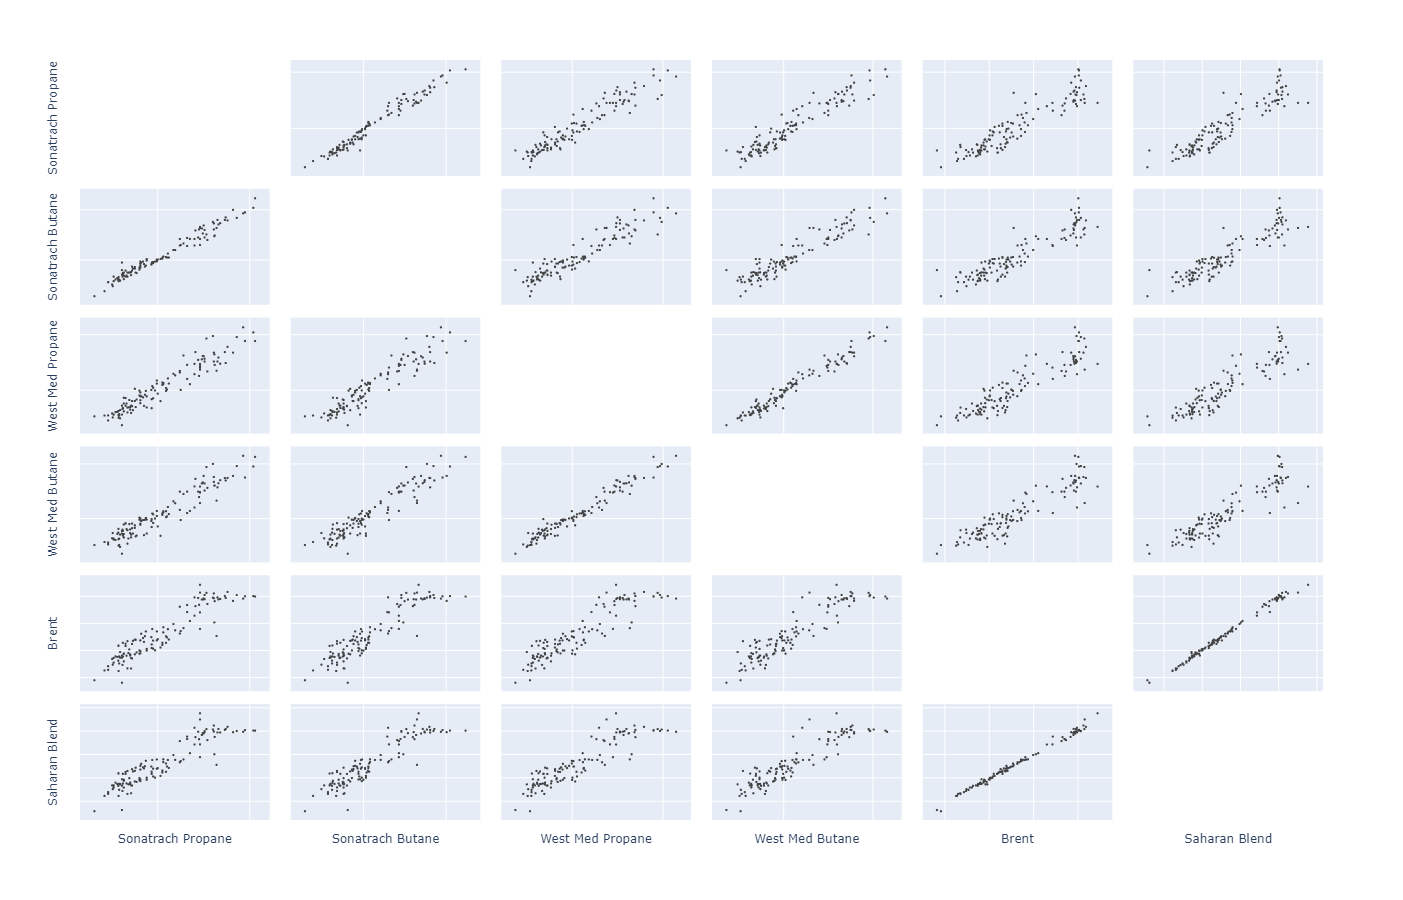

In [191]:
# Understanding relationship between products
fig_scatter = px.scatter_matrix(df, height=900, width=900)

fig_scatter.update_traces(marker=dict(size=1, color="blue", line=dict(width=1)),
                          diagonal_visible=False)

fig_scatter.update_layout(
    {
        "font": {"size": 10}
    }
)

fig_scatter.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(7)})
fig_scatter.update_layout({"yaxis"+str(i+1): dict(showticklabels = False) for i in range(7)})
fig_scatter.show()

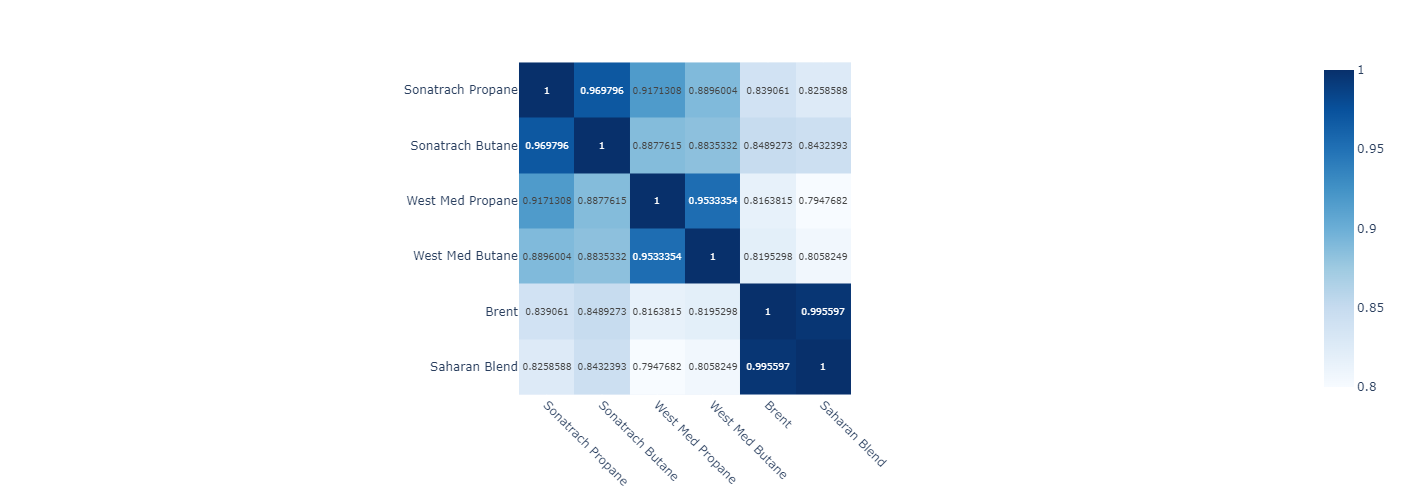

In [196]:
# Correlation between prices
df_last = df.iloc[60:,:]
corr = df_last.corr()
fig = px.imshow(corr, zmin=0.8, height=500, width=600, color_continuous_scale='blues', text_auto=True)
fig.update_layout(
    xaxis = dict(tickangle=45)
)
fig

In [3]:
# Calculating log returns
df['Sonatrach C3, log_ret, %'] = (np.log(df['Sonatrach Propane']) - np.log(df['Sonatrach Propane'].shift(1))) * 100
df['Sonatrach C4, log_ret, %'] = (np.log(df['Sonatrach Butane']) - np.log(df['Sonatrach Butane'].shift(1))) * 100
df['West Med C3, log_ret, %'] = (np.log(df['West Med Propane']) - np.log(df['West Med Propane'].shift(1))) * 100
df['West Med C4, log_ret, %'] = (np.log(df['West Med Butane']) - np.log(df['West Med Butane'].shift(1))) * 100
df['Brent, log_ret, %'] = (np.log(df['Brent']) - np.log(df['Brent'].shift(1))) * 100
df['Saharan Blend, log_ret, %'] = (np.log(df['Saharan Blend']) - np.log(df['Saharan Blend'].shift(1))) * 100

df_ret = df.iloc[1:,6:]
df_ret

,"Sonatrach C3, log_ret, %","Sonatrach C4, log_ret, %","West Med C3, log_ret, %","West Med C4, log_ret, %","Brent, log_ret, %","Saharan Blend, log_ret, %"
Date,,,,,,
2012-09-30,19.53,19.65,1.33,0.87,-1.92,-1.98
2012-10-31,3.69,4.75,8.60,9.21,-3.34,-0.82
2012-11-30,5.54,5.52,-4.38,-9.56,2.30,1.26
2012-12-31,-4.51,-4.49,-7.89,-10.92,-0.11,0.55
2013-01-31,-10.25,-8.52,-5.74,-0.46,3.92,3.40
...,...,...,...,...,...,...
2022-04-30,4.71,7.83,-6.32,3.09,1.32,-0.04
2022-05-31,-17.54,-10.78,-1.07,-6.85,11.64,15.21
2022-06-30,0.00,-1.20,-7.28,-21.11,-6.76,-5.68


In [108]:
df_ret.describe()

,"Sonatrach C3, log_ret, %","Sonatrach C4, log_ret, %","West Med C3, log_ret, %","West Med C4, log_ret, %","Brent, log_ret, %","Saharan Blend, log ret, %"
count,120.00,120.00,120.00,120.00,120.00,120.00
mean,-0.12,-0.14,-0.39,-0.47,-0.16,-0.07
std,13.92,15.90,13.38,15.81,11.95,15.80
min,-67.69,-102.72,-41.13,-71.11,-79.82,-113.61
25%,-7.95,-8.61,-8.01,-8.33,-4.92,-5.27
50%,1.54,1.32,1.30,0.01,1.12,0.56
75%,7.75,7.40,7.63,8.67,5.83,6.08
max,30.37,32.77,36.10,38.32,33.51,76.62


In [119]:
# Preparing data for visualization
max_returns_cols = df_ret.describe().loc['max'].sort_values(ascending=False).index
max_returns_data = [df_ret[col] for col in max_returns_cols]

In [135]:
# Naive risk metrics 
total_obs = len(df_ret)
risk_aversion = -5

non_negative_c3_ret = len(df_ret[df_ret['Sonatrach C3, log_ret, %'] >= risk_aversion]) / total_obs
non_negative_c4_ret = len(df_ret[df_ret['Sonatrach C4, log_ret, %'] >= risk_aversion]) / total_obs

print(f'Sonatrach C3 doesn\'t yield negative MoM returns in {non_negative_c3_ret*100}% of obs')
print(f'Sonatrach C4 doesn\'t yield negative MoM returns in {non_negative_c4_ret*100}% of obs')

Sonatrach C3 doesn't yield negative MoM returns in 68.33333333333333% of obs
Sonatrach C4 doesn't yield negative MoM returns in 70.0% of obs


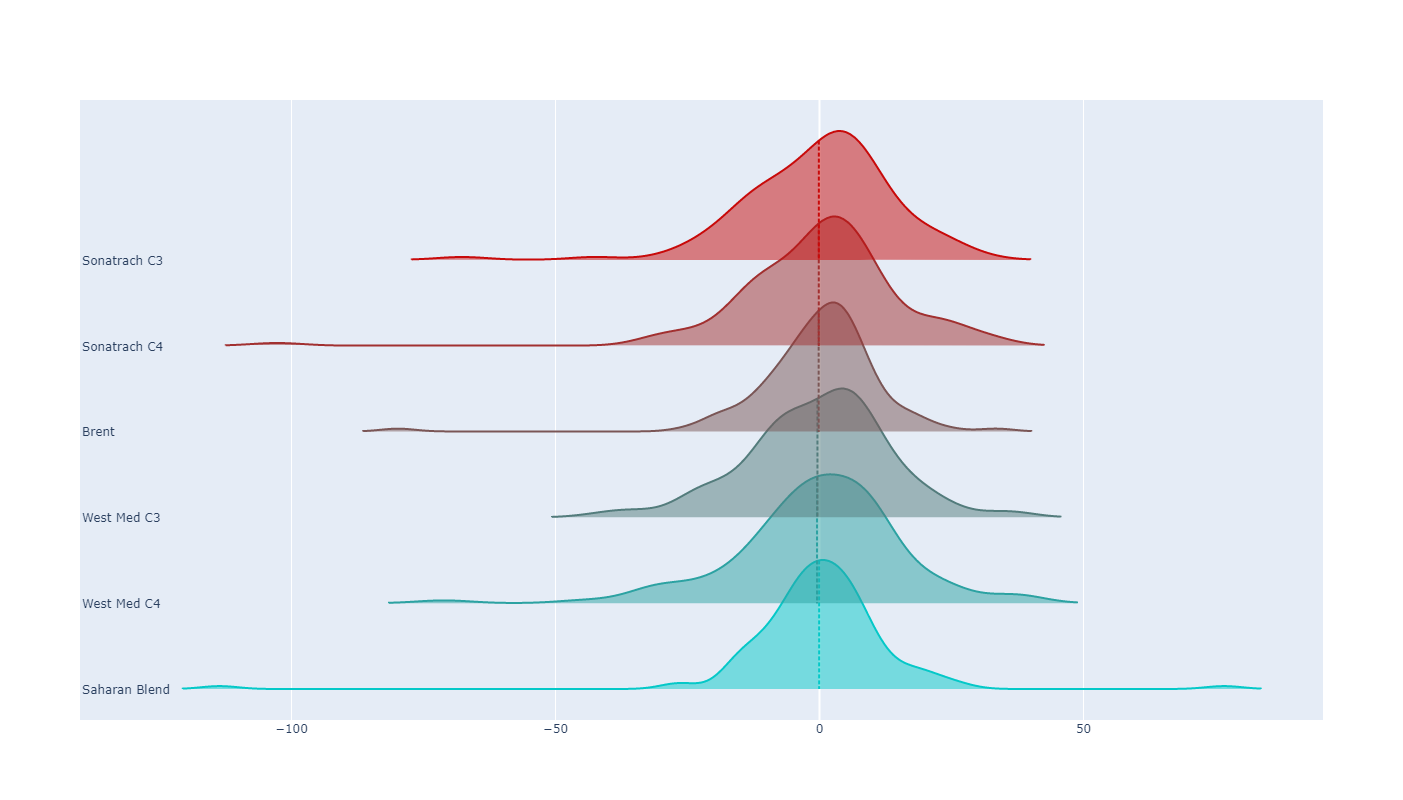

In [126]:
# Coloring traces with different colors
colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 6, colortype='rgb')


ridgeline_fig = go.Figure()
y = -1

for data_line, color in zip(max_returns_data, colors):
    
    y += 1
    
    ridgeline_fig.add_trace(go.Violin(x=data_line, line_color=color, meanline_visible=True))
    ridgeline_fig.add_annotation(xref='x', x=-125, y=y, text=data_line.name[:-12], showarrow=False, align='left', width=155)
    
ridgeline_fig.update_traces(orientation='h', side='positive', width=3, points=False)
ridgeline_fig.update_layout(xaxis_showgrid=True, xaxis_zeroline=True, yaxis_showticklabels=False, showlegend=False, width=1000, height=800)


ridgeline_fig

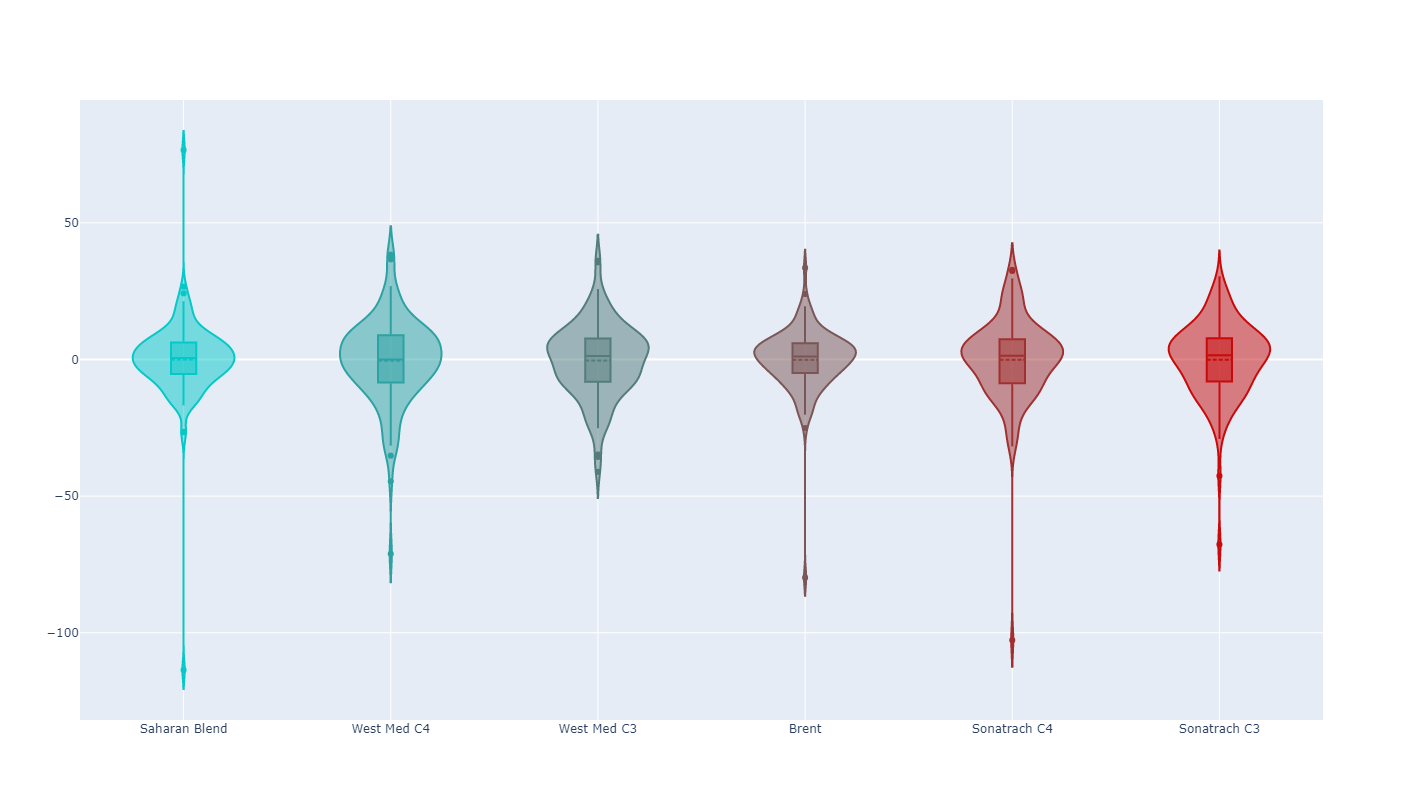

In [123]:
violin_fig = go.Figure()

for data_line, color in zip(max_returns_data, colors):
   
    violin_fig.add_trace(go.Violin(y=data_line, line_color=color, orientation='v', name=data_line.name[:-12], meanline_visible=True, box_visible=True))
    
violin_fig.update_layout(xaxis_showgrid=True, xaxis_zeroline=True, showlegend=False, width=1000, height=800)
violin_fig

In [127]:
dist_prop = pd.concat([df_ret.skew(), df_ret.kurtosis()],axis=1)
dist_prop.columns = ['Skewness', 'Kurtosis']
dist_prop.T

,"Sonatrach C3, log_ret, %","Sonatrach C4, log_ret, %","West Med C3, log_ret, %","West Med C4, log_ret, %","Brent, log_ret, %","Saharan Blend, log ret, %"
Skewness,-1.11,-2.18,-0.26,-0.85,-2.39,-2.16
Kurtosis,4.12,13.67,0.78,3.20,16.02,25.88


In [28]:
# FIRST TRY
# Brent daily prices
brent = pd.read_excel('brent.xlsx')
brent

,Exchange Date,Close,Net,%Chg,Open,Low,High,Volume,OI
0,2022-08-18,93.50,-0.15,-0.00,93.29,93.05,93.90,6466.00,NaN
1,2022-08-17,93.65,1.31,0.01,92.67,91.51,94.48,199193.00,NaN
2,2022-08-16,92.34,-2.76,-0.03,94.01,91.71,95.95,217751.00,260011.00
3,2022-08-15,95.10,-3.05,-0.03,97.72,92.78,98.17,217574.00,270582.00
4,2022-08-12,98.15,-1.45,-0.01,99.33,96.94,100.38,188126.00,271289.00
...,...,...,...,...,...,...,...,...,...
2557,2012-09-24,109.81,-1.61,-0.01,111.50,108.78,111.56,187245.00,208997.00
2558,2012-09-21,111.42,1.39,0.01,110.50,110.08,111.70,161966.00,213985.00
2559,2012-09-20,110.03,1.84,0.02,108.18,107.10,110.65,250449.00,229950.00
2560,2012-09-19,108.19,-3.84,-0.03,111.71,107.40,112.98,298801.00,223480.00


In [3]:
brent.dtypes

Exchange Date    datetime64[ns]
Close                   float64
Net                     float64
%Chg                    float64
Open                    float64
Low                     float64
High                    float64
Volume                  float64
OI                      float64
dtype: object

In [9]:
brent.index = brent['Exchange Date']
brent = brent[['Close']]
brent.sort_index(inplace=True)
brent.Close.dropna().iloc[2162:]

C:\Users\bcherkasov\Anaconda3\lib\site-packages\pandas\core\frame.py:6393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


Exchange Date
2021-02-04   58.84
2021-02-05   59.34
2021-02-08   60.56
2021-02-09   61.09
2021-02-10   61.47
              ... 
2022-08-12   98.15
2022-08-15   95.10
2022-08-16   92.34
2022-08-17   93.65
2022-08-18   93.50
Name: Close, Length: 399, dtype: float64

In [10]:
brent_returns = np.log(brent['Close']) - np.log(brent['Close'].shift(1))
brent_returns.sort_index(inplace=True)
brent_returns.dropna().iloc[2162:]

Exchange Date
2021-02-08    0.02
2021-02-09    0.01
2021-02-10    0.01
2021-02-11   -0.01
2021-02-12    0.02
              ... 
2022-08-12   -0.01
2022-08-15   -0.03
2022-08-16   -0.03
2022-08-17    0.01
2022-08-18   -0.00
Name: Close, Length: 397, dtype: float64

In [11]:
# Splitting data set into training and testing sets 80% / 20%
train, test = pmdarima.model_selection.train_test_split(brent.Close.dropna()[2162:], train_size = 0.8)
training, testing = pmdarima.model_selection.train_test_split(brent_returns.dropna()[2162:], train_size = 0.8)

C:\Users\bcherkasov\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1826: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\bcherkasov\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1826: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\bcherkasov\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gennorm,673.26,28.09,256.05,inf,0.04,0.59
laplace,674.99,37.35,251.10,inf,0.04,0.71
loglaplace,675.08,41.01,256.91,inf,0.04,0.70
dweibull,690.44,10.70,264.04,inf,0.04,0.74
norminvgauss,695.88,-5.94,272.28,inf,0.03,0.95


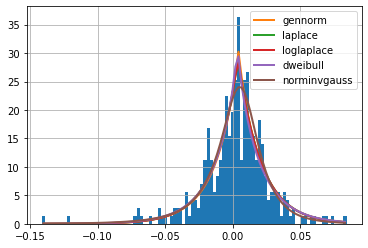

In [12]:
f = Fitter(training, timeout=120)
f.fit()
f.summary()

In [13]:
#f.fitted_param['loglaplace']
f.get_best('bic')

{'laplace': {'loc': 0.0039032517472668005, 'scale': 0.01725635677604911}}

In [14]:
def GBMsimulator(So, mu, sigma, T, N):
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.laplace.rvs(loc=0.0039032517472668005,
                                        scale=0.01725635677604911)

            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]

In [23]:
prices = GBMsimulator(So = brent.Close.iloc[len(train)], mu = training.mean(), sigma = training.std(), T = len(test), N = 1)
newpreds = pd.DataFrame(prices)

In [24]:
mape(newpreds, test.dropna())

0.08582172275838158

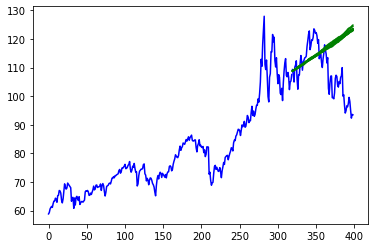

In [22]:
axis = np.arange(len(train) + len(test))
plt.plot(axis[:len(train)], train, c = "blue")
plt.plot(axis[len(train):], test, c = "blue")
plt.plot(axis[len(train):], np.array(newpreds), c = "green")

In [30]:
# ANOTHER TRY
brent.index = brent['Exchange Date']
brent = brent[['Open', 'Low', 'High', 'Close', 'Volume']]
brent

,Open,Low,High,Close,Volume
Exchange Date,,,,,
2022-08-18,93.29,93.05,93.90,93.50,6466.00
2022-08-17,92.67,91.51,94.48,93.65,199193.00
2022-08-16,94.01,91.71,95.95,92.34,217751.00
2022-08-15,97.72,92.78,98.17,95.10,217574.00
2022-08-12,99.33,96.94,100.38,98.15,188126.00
...,...,...,...,...,...
2012-09-24,111.50,108.78,111.56,109.81,187245.00
2012-09-21,110.50,110.08,111.70,111.42,161966.00
2012-09-20,108.18,107.10,110.65,110.03,250449.00


In [31]:
brent.dropna(how='any', inplace=True)

C:\Users\bcherkasov\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [32]:
brent.sort_index(inplace=True)
brent

C:\Users\bcherkasov\Anaconda3\lib\site-packages\pandas\core\frame.py:6393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


,Open,Low,High,Close,Volume
Exchange Date,,,,,
2012-09-18,113.45,111.61,114.42,112.03,212109.00
2012-09-19,111.71,107.40,112.98,108.19,298801.00
2012-09-20,108.18,107.10,110.65,110.03,250449.00
2012-09-21,110.50,110.08,111.70,111.42,161966.00
2012-09-24,111.50,108.78,111.56,109.81,187245.00
...,...,...,...,...,...
2022-08-12,99.33,96.94,100.38,98.15,188126.00
2022-08-15,97.72,92.78,98.17,95.10,217574.00
2022-08-16,94.01,91.71,95.95,92.34,217751.00


In [33]:
def convert_bbl_mt(x):
    return x / 0.138

cols = ['Open', 'Low', 'High','Close']
brent = brent[cols].applymap(lambda x: convert_bbl_mt(x))

In [25]:
propane = df[['Sonatrach Propane']]
propane.columns = ['Close']
propane['Open'] = propane['Close']
propane

C:\Users\BCHERK~1\AppData\Local\Temp/ipykernel_9324/3595615189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propane['Open'] = propane['Close']


,Close,Open
Date,,
2012-08-31,765,765
2012-09-30,930,930
2012-10-31,965,965
2012-11-30,1020,1020
2012-12-31,975,975
...,...,...
2022-04-30,870,870
2022-05-31,730,730
2022-06-30,730,730


In [56]:
butane = df[['Sonatrach Butane']]
butane.columns = ['Close']
butane['Open'] = butane['Close']
butane

C:\Users\BCHERK~1\AppData\Local\Temp/ipykernel_9324/1676041171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  butane['Open'] = butane['Close']


,Close,Open
Date,,
2012-08-31,760,760
2012-09-30,925,925
2012-10-31,970,970
2012-11-30,1025,1025
2012-12-31,980,980
...,...,...
2022-04-30,930,930
2022-05-31,835,835
2022-06-30,825,825


2012-10-15T00:00:00, BUY CREATE, exectype Market, price 925.00
2012-09-30T00:00:00, ORDER ACCEPTED/SUBMITTED
2012-09-30T00:00:00, ORDER ACCEPTED/SUBMITTED
2012-10-31T00:00:00, BUY EXECUTED, Price: 925.00, Cost: 925.00, Comm 0.00
2012-10-31T00:00:00, ORDER ACCEPTED/SUBMITTED
2012-10-31T00:00:00, ORDER ACCEPTED/SUBMITTED
2012-11-15T00:00:00, BUY CREATE, exectype Market, price 970.00
2012-10-31T00:00:00, ORDER ACCEPTED/SUBMITTED
2012-11-30T00:00:00, SELL EXECUTED, Price: 970.00, Cost: 925.00, Comm 0.00
2013-02-15T00:00:00, BUY CREATE, exectype Market, price 900.00
2013-01-31T00:00:00, ORDER ACCEPTED/SUBMITTED
2013-01-31T00:00:00, ORDER ACCEPTED/SUBMITTED
2013-02-28T00:00:00, BUY EXECUTED, Price: 900.00, Cost: 900.00, Comm 0.00
2013-02-28T00:00:00, ORDER ACCEPTED/SUBMITTED
2013-02-28T00:00:00, ORDER ACCEPTED/SUBMITTED
2013-03-28T00:00:00, SELL EXECUTED, Price: 905.00, Cost: 900.00, Comm 0.00
2013-05-15T00:00:00, BUY CREATE, exectype Market, price 810.00
2013-04-30T00:00:00, ORDER ACCEPTED/

<IPython.core.display.Javascript object>

[[<Figure size 1800x1200 with 6 Axes>]]

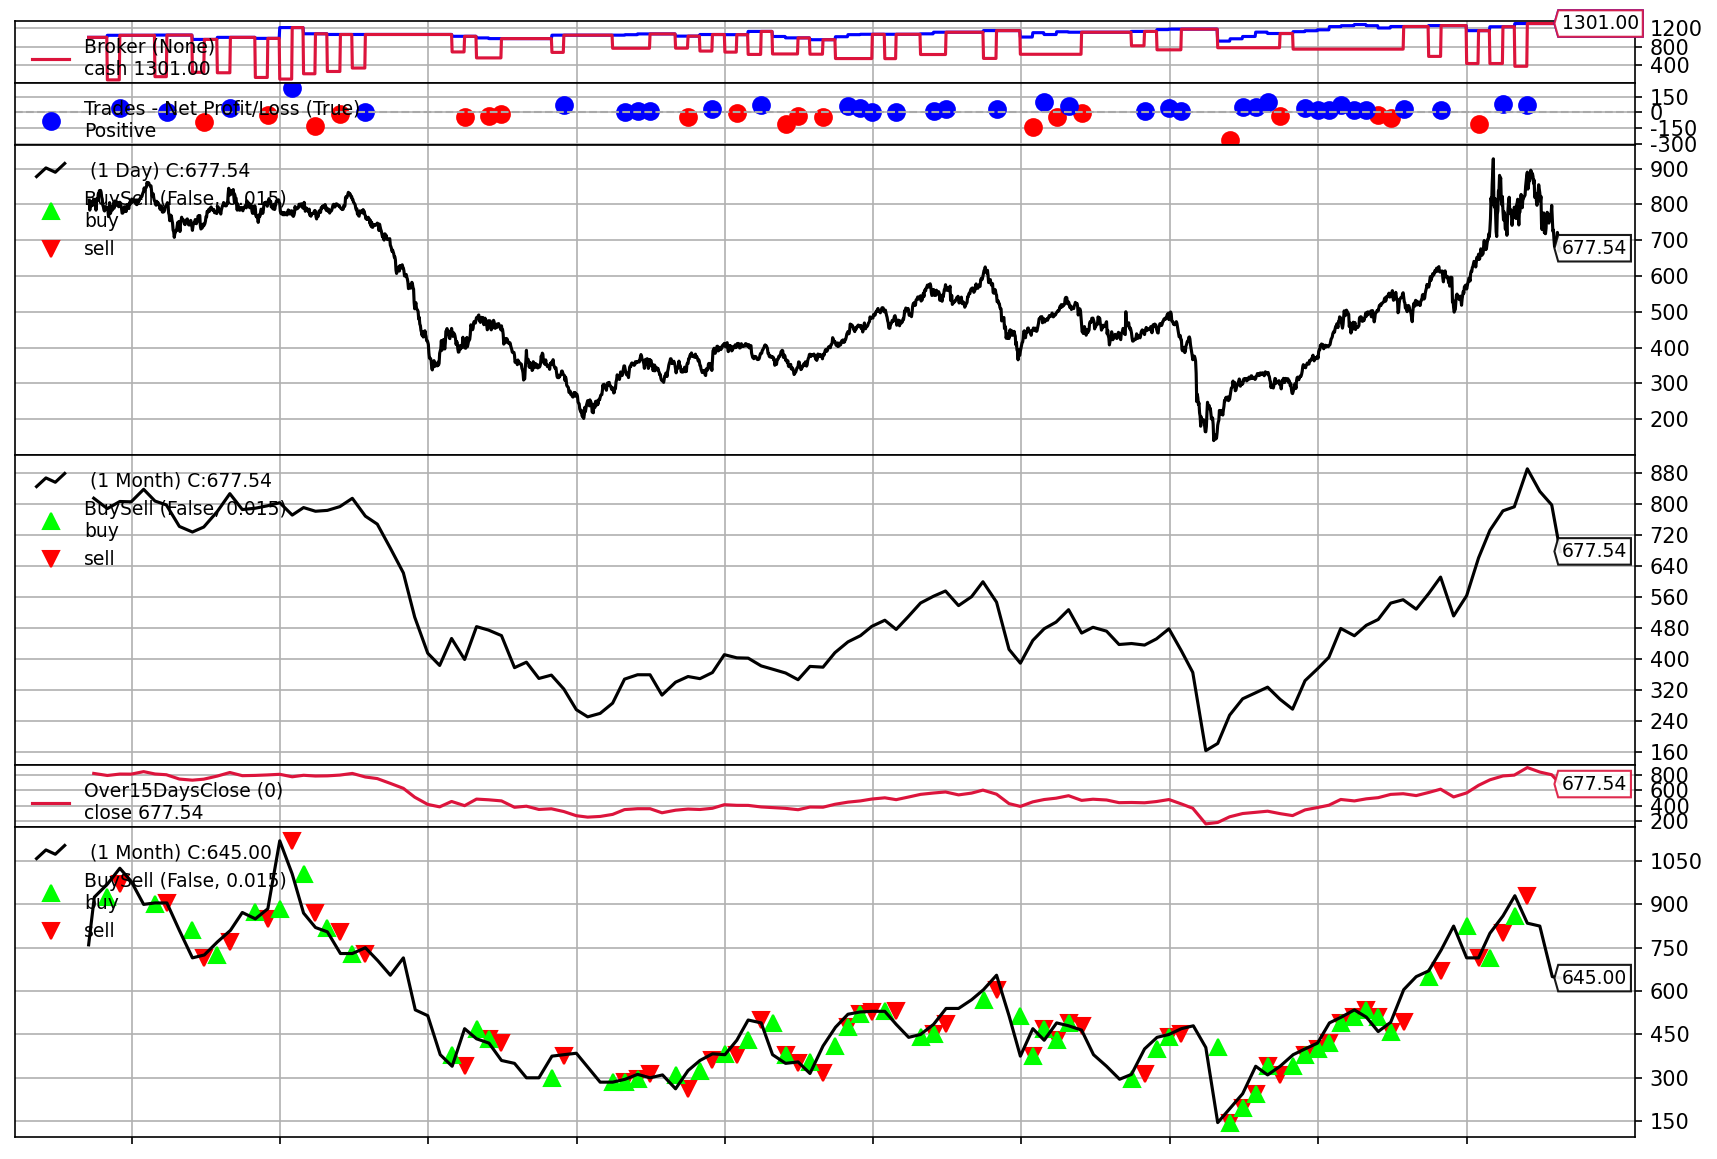

In [57]:
#%matplotlib inline
data_bt = bt.feeds.PandasData(dataname=brent,
                              timeframe=bt.TimeFrame.Days) 

c3_bt = bt.feeds.PandasData(dataname=propane,
                            close='Close', open=None, low=None, high=None,
                            volume=None, openinterest=None,
                            timeframe=bt.TimeFrame.Months) 


c4_bt = bt.feeds.PandasData(dataname=butane,
                            close='Close', open=None, low=None, high=None,
                            volume=None, openinterest=None,
                            timeframe=bt.TimeFrame.Months) 

# initialize backtrader broker
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)
cerebro.broker.setcash(1000)
cerebro.broker.set_coc(True)
cerebro.broker.setcommission(commission=0)
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobservermulti(bt.observers.BuySell)


# add strategy

cerebro.adddata(data_bt)

cerebro.resampledata(data_bt,
                         timeframe=bt.TimeFrame.Months,
                         compression=1)


cerebro.adddata(c4_bt)

cerebro.addstrategy(Store2Win)

# run backtest
res = cerebro.run()
strat = res[0]

#prepare plots
mpl.rcParams['font.sans-serif']=['DejaVu Sans']
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.figsize']=[12, 8]
mpl.rcParams['figure.dpi']=150
mpl.rcParams['figure.facecolor']='w'
mpl.rcParams['figure.edgecolor']='k'
cerebro.plot(style='line',iplot=True,width=10,height=2, volume=False)

In [46]:
class Store2Win(bt.Strategy):
  # list of parameters which are configurable for the strategy
    params = dict(
        when=bt.timer.SESSION_START,
        timer=True,
        cheat=True,
        monthdays=[15],
        monthcarry=True
    )
    
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED', dt=order.created.dt)
            self.order = order
            return

        if order.status in [order.Expired]:
            self.log('BUY EXPIRED')

        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.sell(data=self.data2, exectype=bt.Order.Close)
                return

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

        # Sentinel to None: new orders allowed
        self.order = None
    
    def __init__(self):
       
        self.cheating = self.cerebro.p.cheat_on_open
        self.lclose = lclose = Over15DaysClose(self.data1)
               
        self.add_timer(when=self.p.when,
                           monthdays=self.p.monthdays,
                           monthcarry=True,
                           cheat=True)
        self.order = None
        
                    
    def prenext(self):
        self.next()
        
        
    def next(self):
        
        if self.order:
            # An order is pending ... nothing can be done
            return
        
   
            
        
    def notify_timer(self, timer, when, *args, **kwargs):
        #print(f'it\'s 15th: {}')
        #if self.data0.close[0]
               
        if len(self) > 1:
            #print(f'{self.data0.datetime.date(), self.data0.close[0]} Previous close: {self.lclose[0]}')
            if self.data0.close[0] >= self.lclose[0]:
                self.log('BUY CREATE, exectype Market, price %.2f' %
                         self.data2.close[0])
                self.order = self.buy(data=self.data2, exectype=bt.Order.Close)
                #self.operate(fromopen=True)
                #self.sell(data=self.data2, exectype=bt.Order.Market)
                
            #else:
                #print('sell')
            #    self.sell()
                #self.sell(data=self.data2)
                
                
class Over15DaysClose(bt.Indicator):
    
    lines = ('close',)
    params = (('period', 0),)

    def __init__(self):

        self.lines.close = self.data.close(-self.p.period)